In [3]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("data4.txt")

In [146]:
# Streaming models
# Same data and metaheuristics as before, but this time fitting the data in small batches,
# without letting the algorithms have access to all their historical data

from sklearn.linear_model import SGDClassifier
from contextualbandits.online import AdaptiveGreedy
from copy import deepcopy


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log', max_iter=500)
beta_prior = ((3, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior,
                                      decay_type='percentile', decay=0.9997, batch_train=True)

models = [adaptive_greedy_perc]


In [156]:
# These lists will keep track of the rewards obtained by each policy

rewards_agr2 = []

lst_rewards = [rewards_agr2]


# batch size - algorithms will be refit after N rounds
batch_size = 30

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose

lst_a_agr2 = action_chosen.copy()
lst_actions = [lst_a_agr2]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)

In [76]:
#idx = np.random.randint(len(X))
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in range(5):
    action = models[0].predict(X[i]).astype("uint8")
    print(action)

[1]
[1]
[1]
[1]
[0]


In [64]:
action = models[0].predict(X[0]).astype("uint8")
print(action)

[1]


In [55]:
X[0]

array([ 2.60000000e+01,  2.00000000e+03,  2.00000000e+03,  2.00000000e+03,
        2.14000000e+02, -5.50000000e+01,  2.60000000e+01,  1.84287596e+00,
        4.61077222e-03,  1.26900000e-03,  1.07750000e-02,  1.30000000e+01,
        2.00000000e+01, -1.01000000e+02, -1.40000000e+01,  9.00000000e+00,
       -1.00000000e+01,  1.82739000e+02,  3.42710000e+01,  1.44082000e+02,
        3.80550000e+01,  3.07000000e+02,  2.91709496e-04,  2.65235556e-03,
        1.90700000e-03,  5.53900000e-03,  3.07200000e+03,  5.53972635e-01,
        2.10955724e-01,  4.56550000e+01,  7.84300000e+00,  1.36690891e-01,
        6.47130717e-02,  1.49640000e+02,  1.40217000e+02,  0.00000000e+00,
        0.00000000e+00])

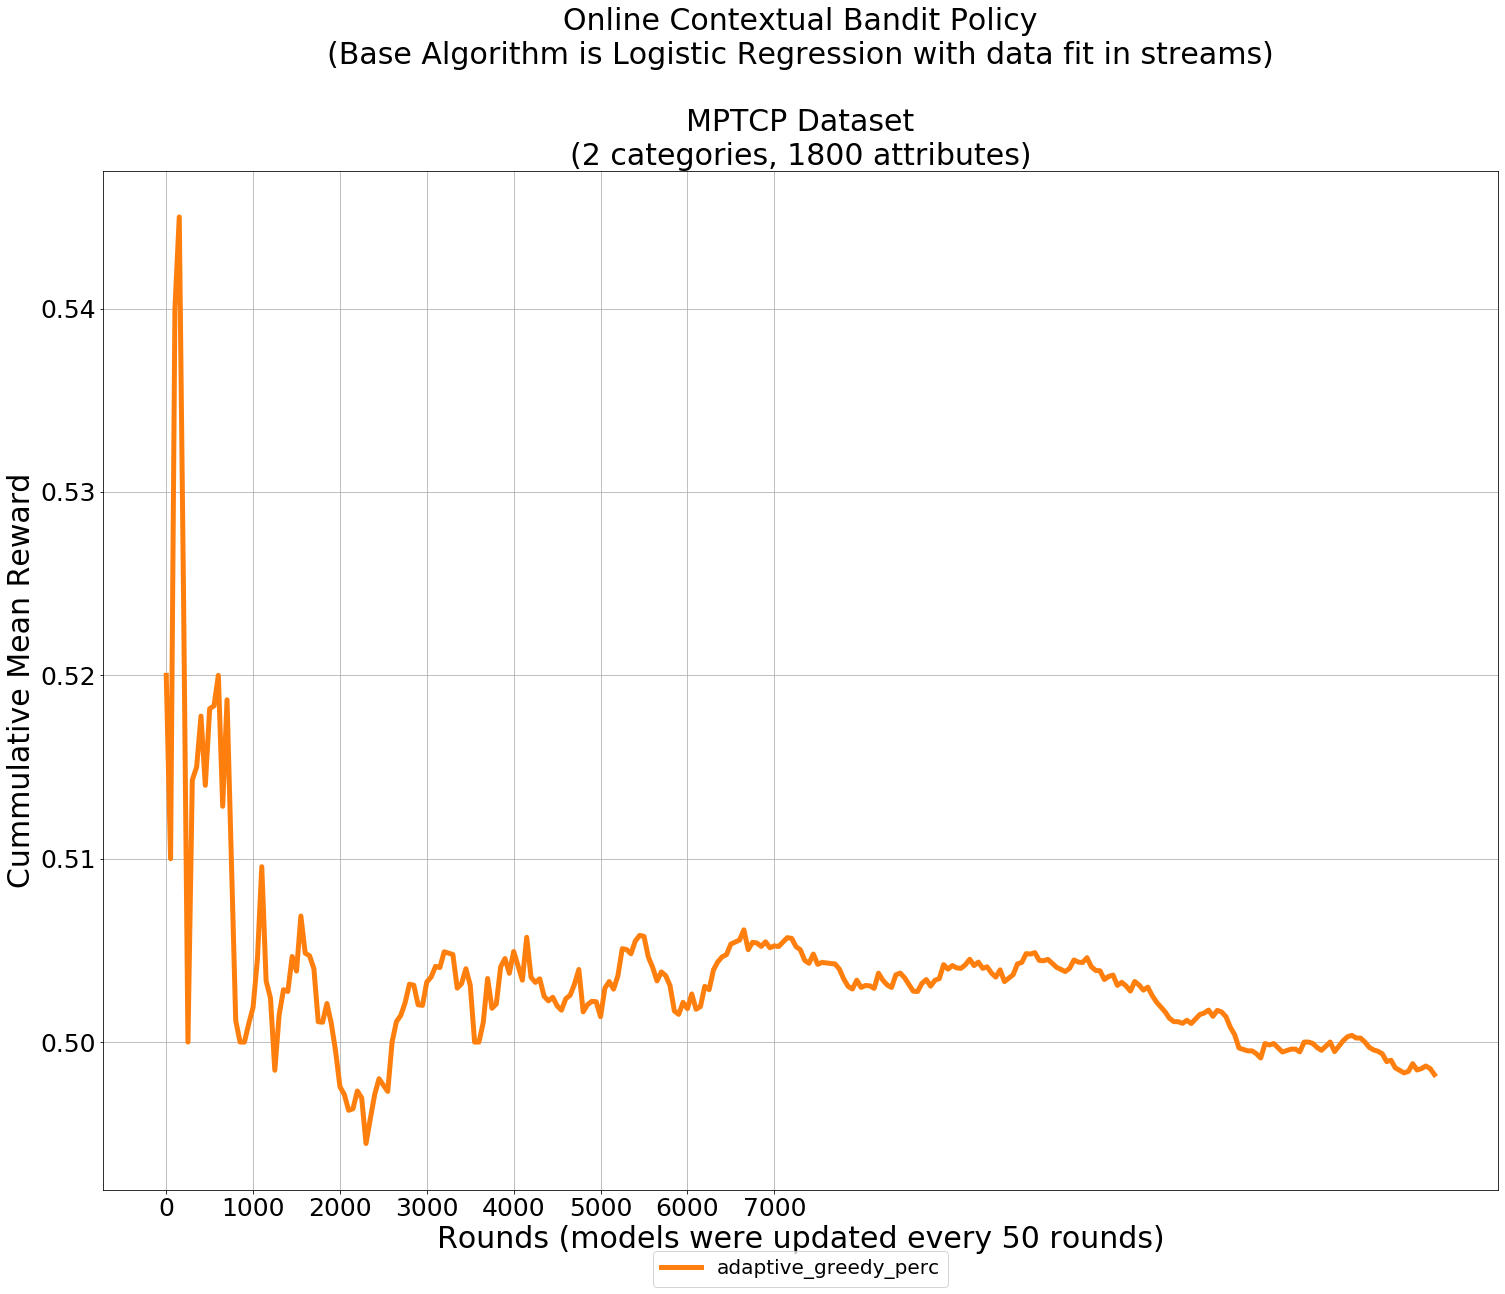

In [59]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Online Contextual Bandit Policy\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [33]:
idx

[0, 1]

In [29]:
print(idx)

range(0, 10)


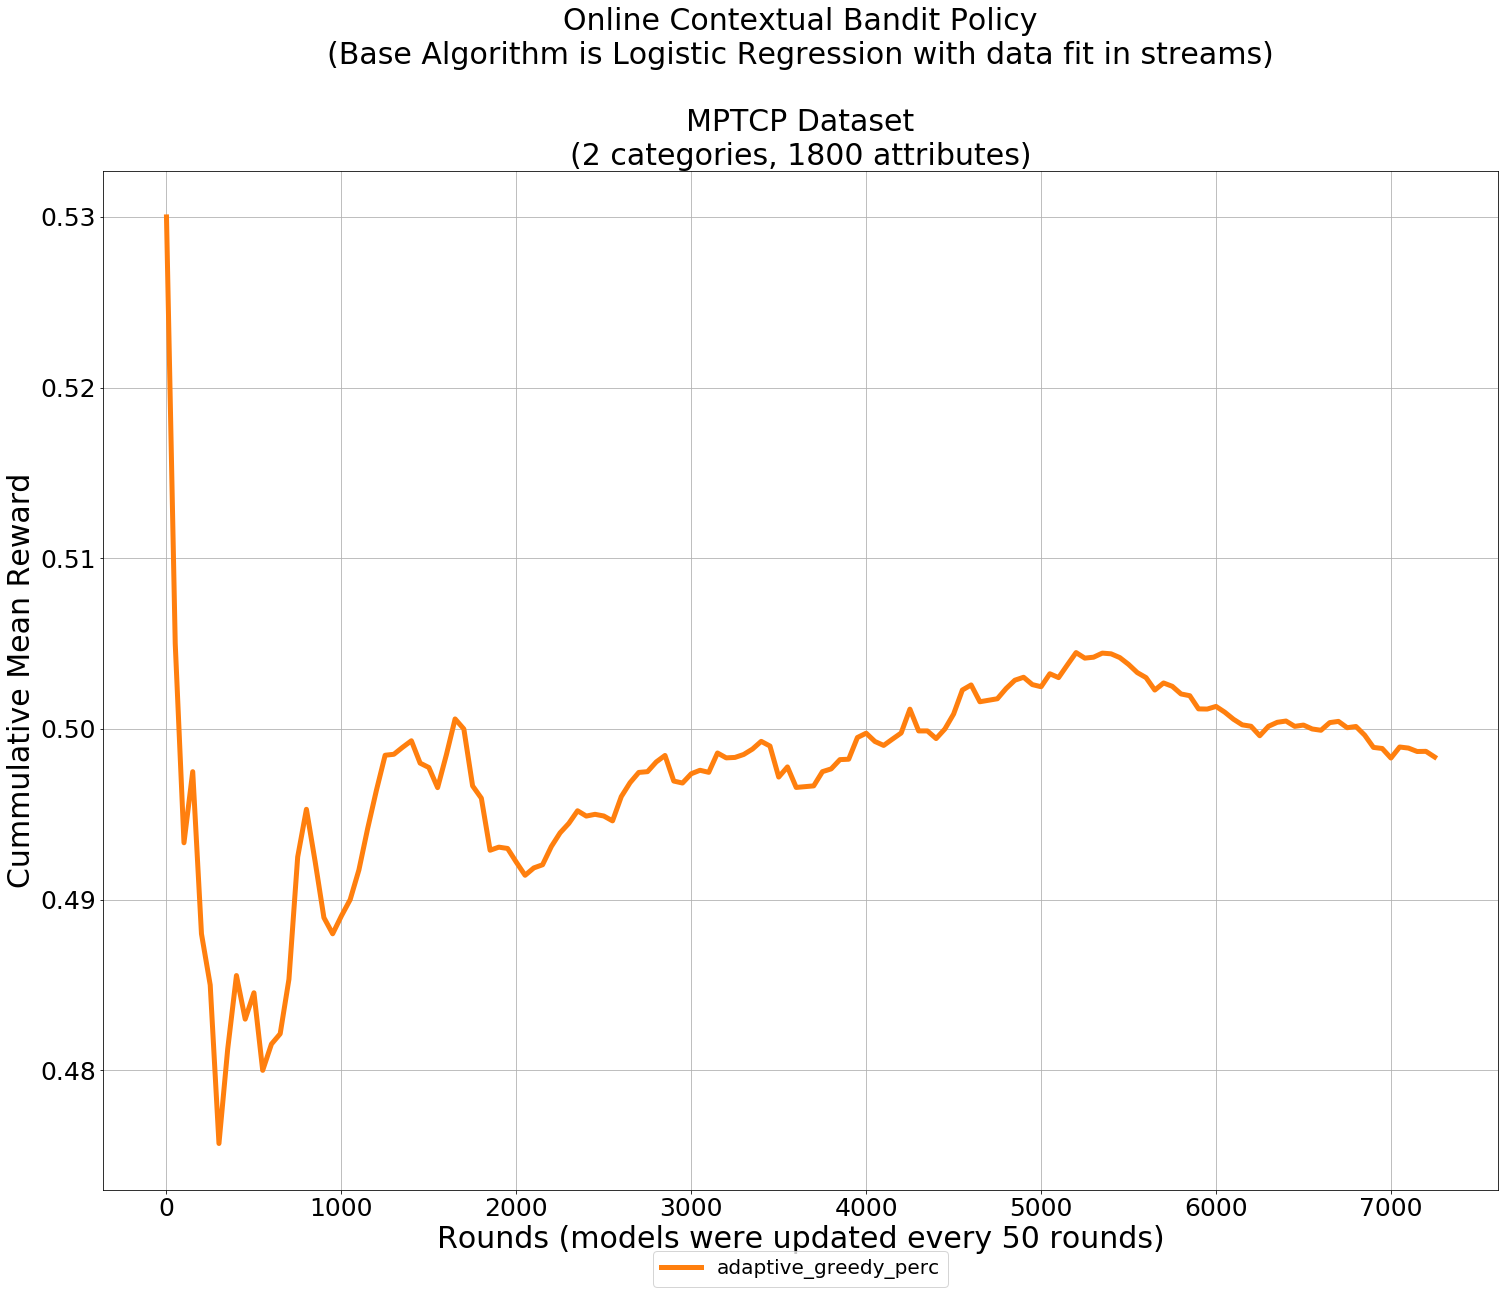

In [78]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Online Contextual Bandit Policy\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

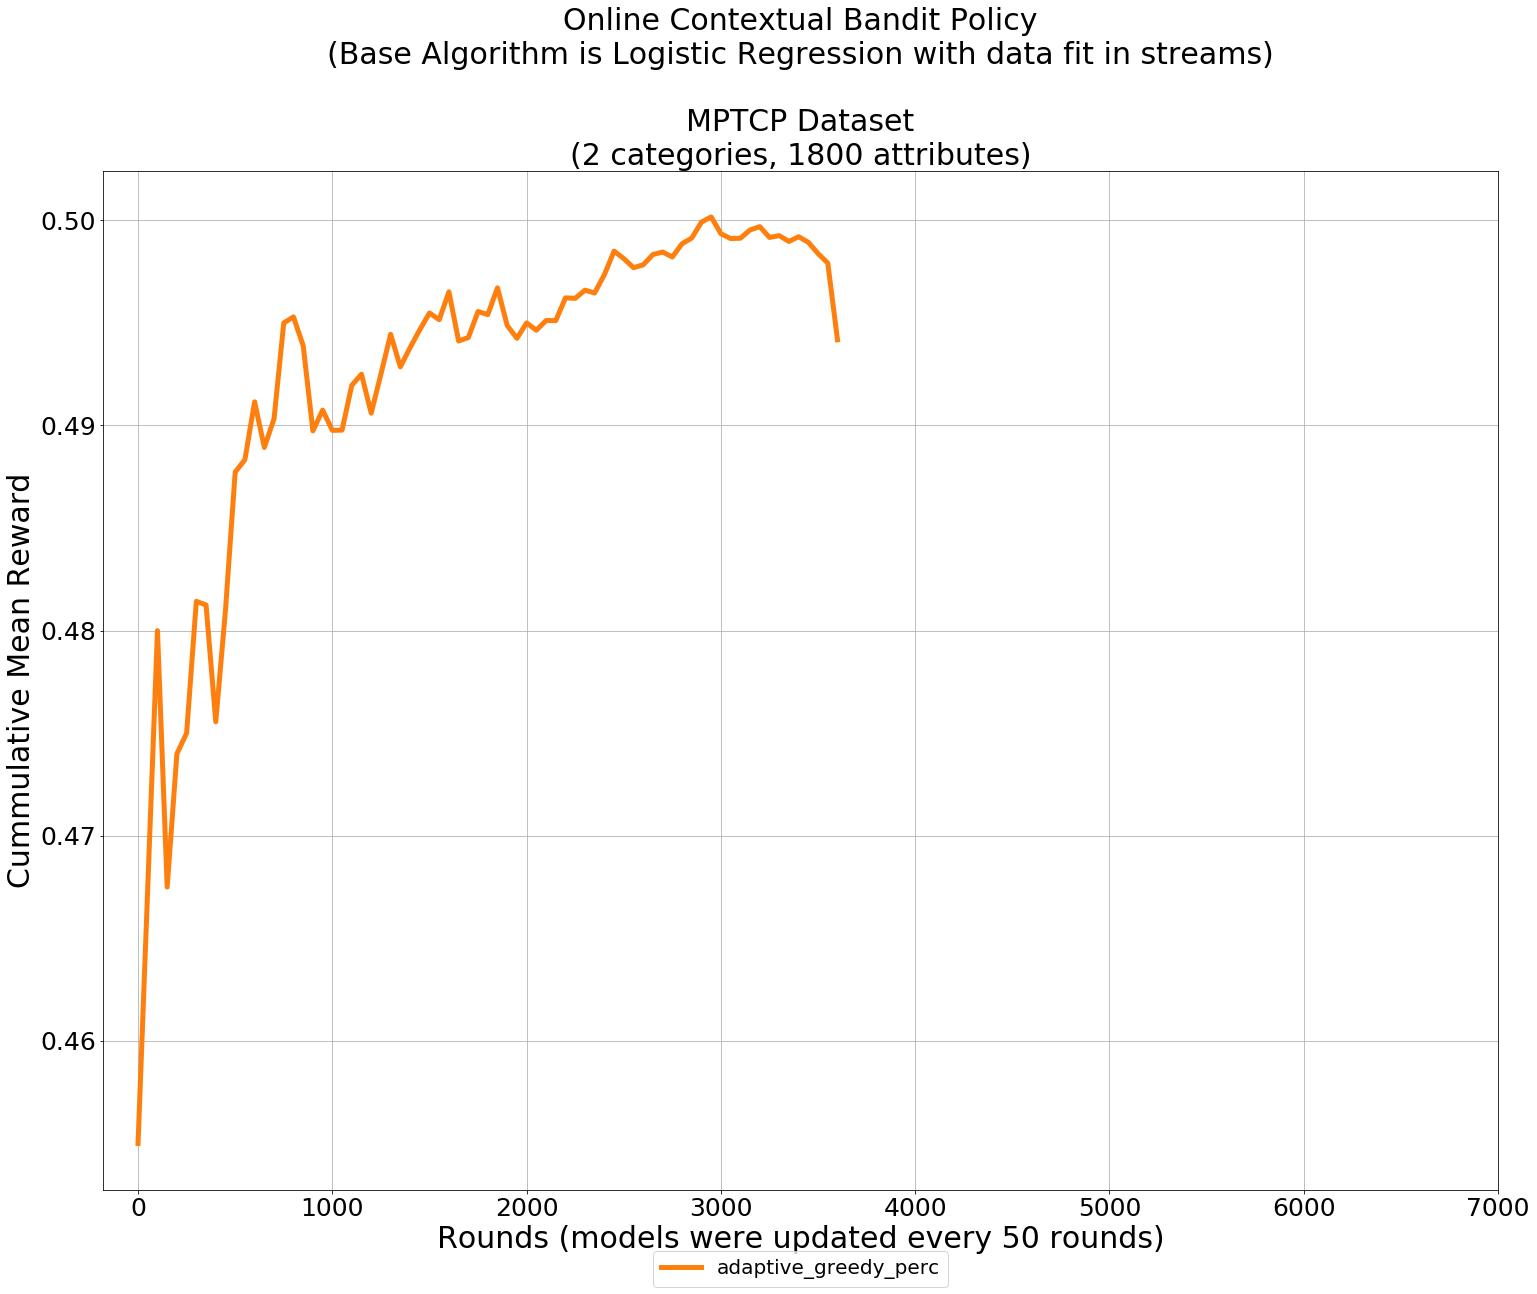

In [80]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('Online Contextual Bandit Policy\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

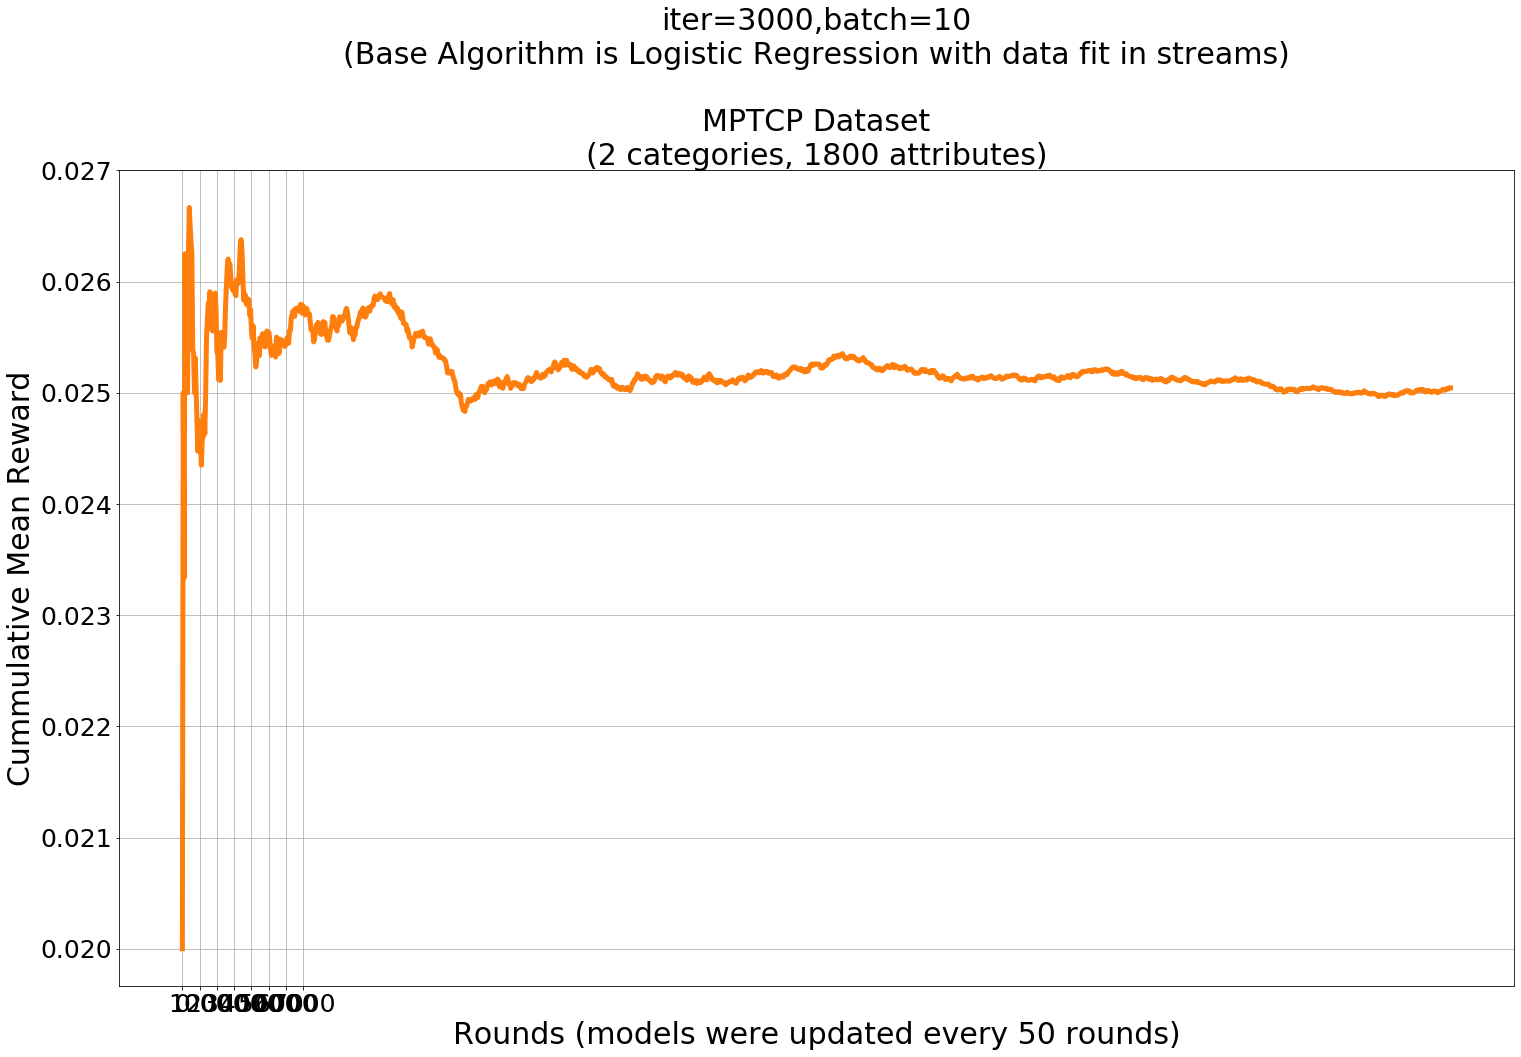

In [85]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=3000,batch=10\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [88]:
#idx = np.random.randint(len(X))
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in range(5):
    action = models[0].predict(X[i]).astype("uint8")
    print(action)

[0]
[1]
[0]
[1]
[0]


In [96]:
action = models[0].predict(X[0]).astype("uint8")
print(action)

[0]


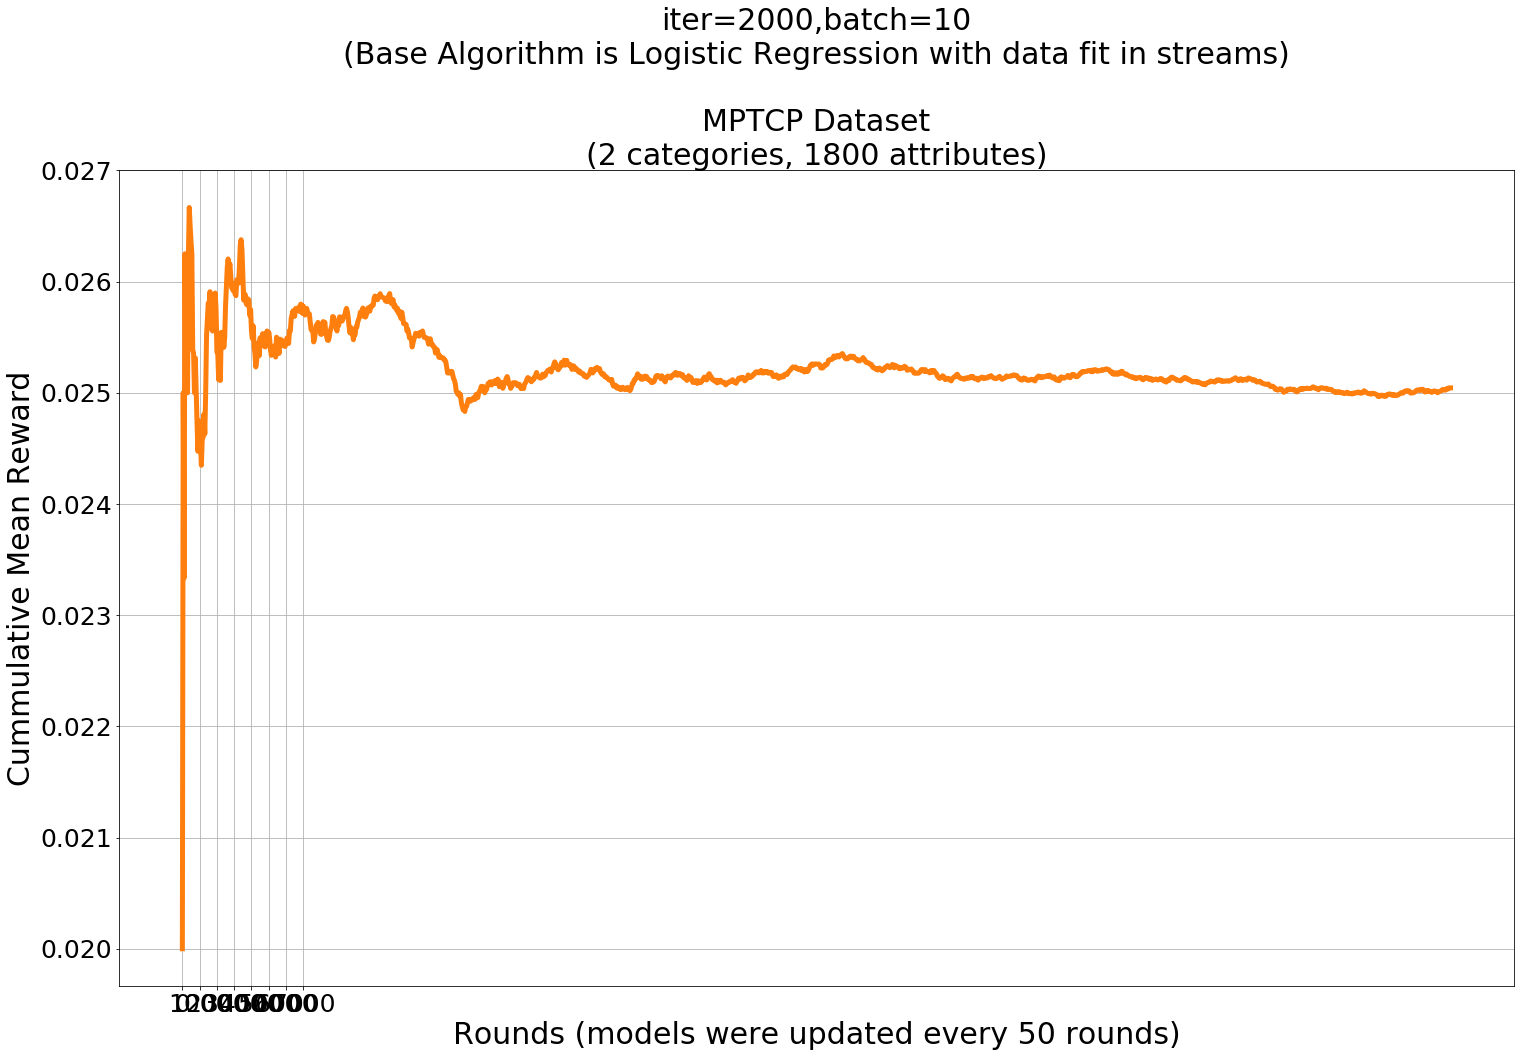

In [99]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=2000,batch=10\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

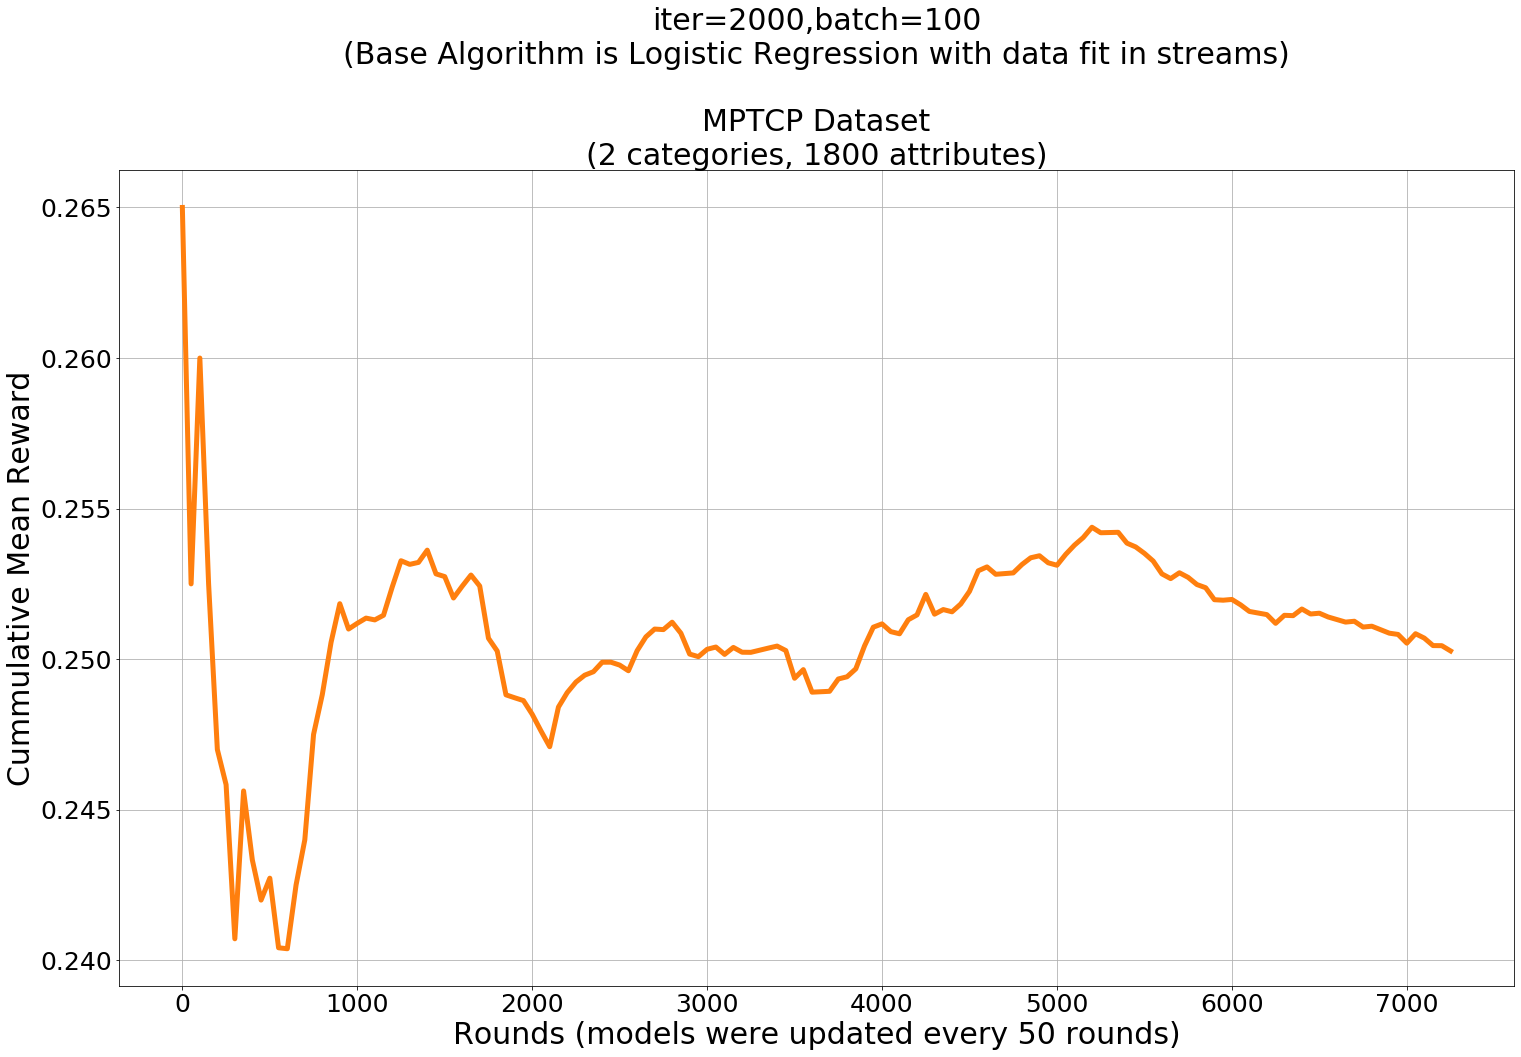

In [101]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=2000,batch=100\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

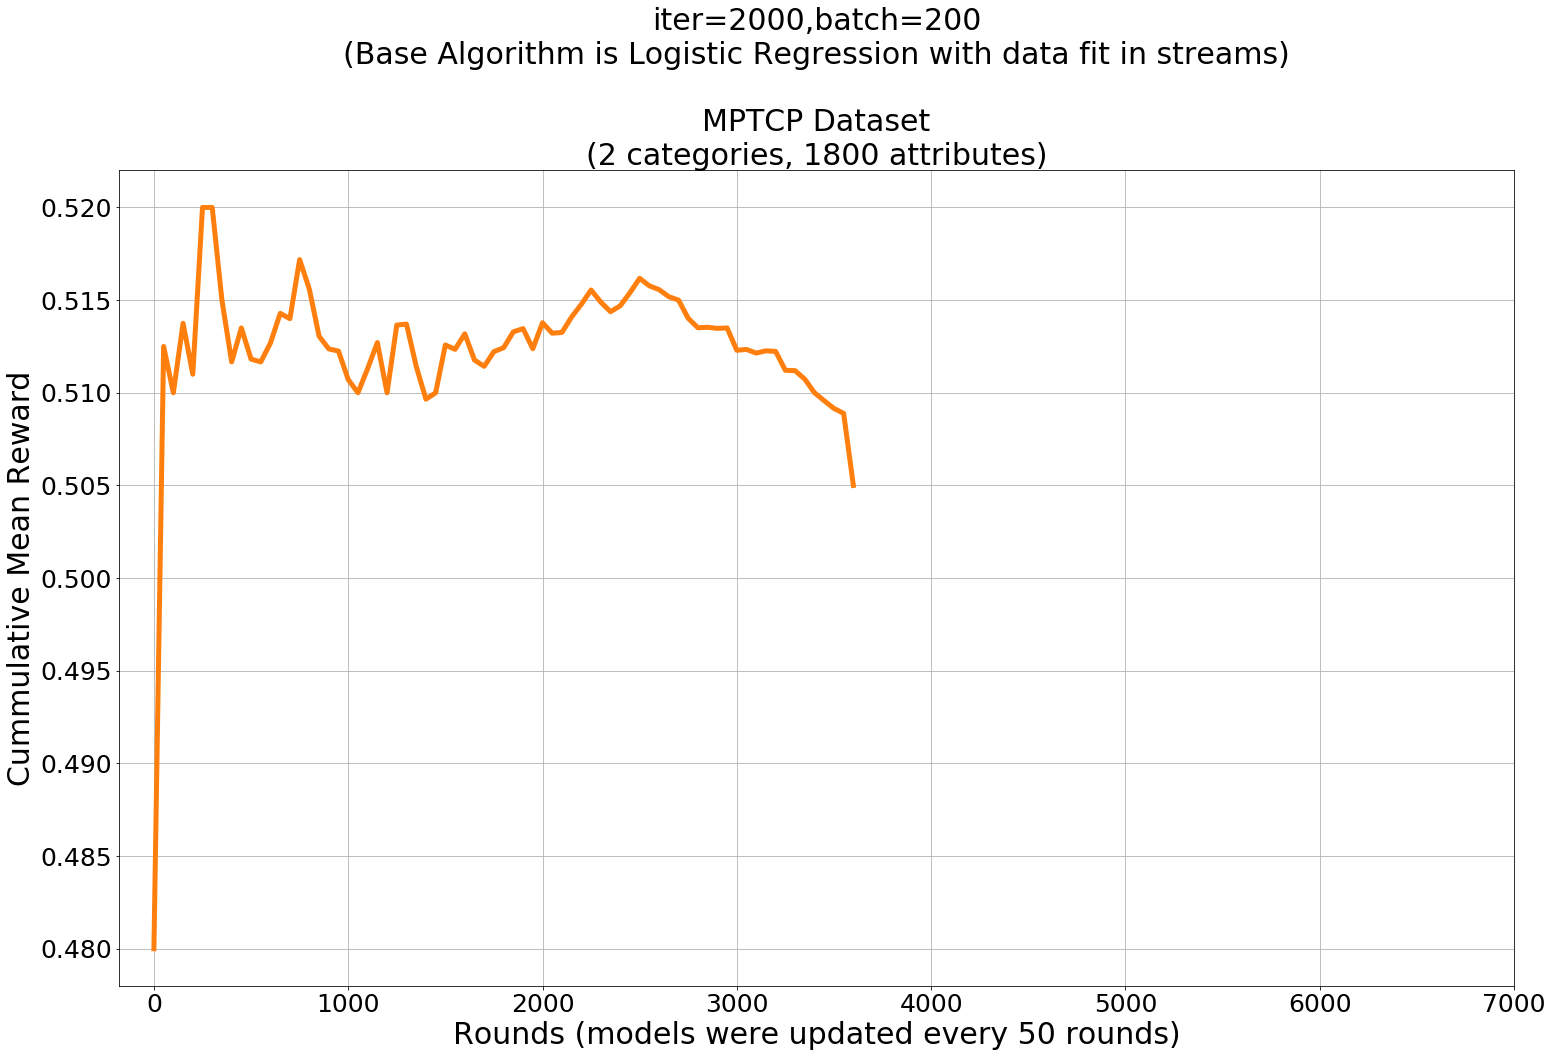

In [103]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=2000,batch=200\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

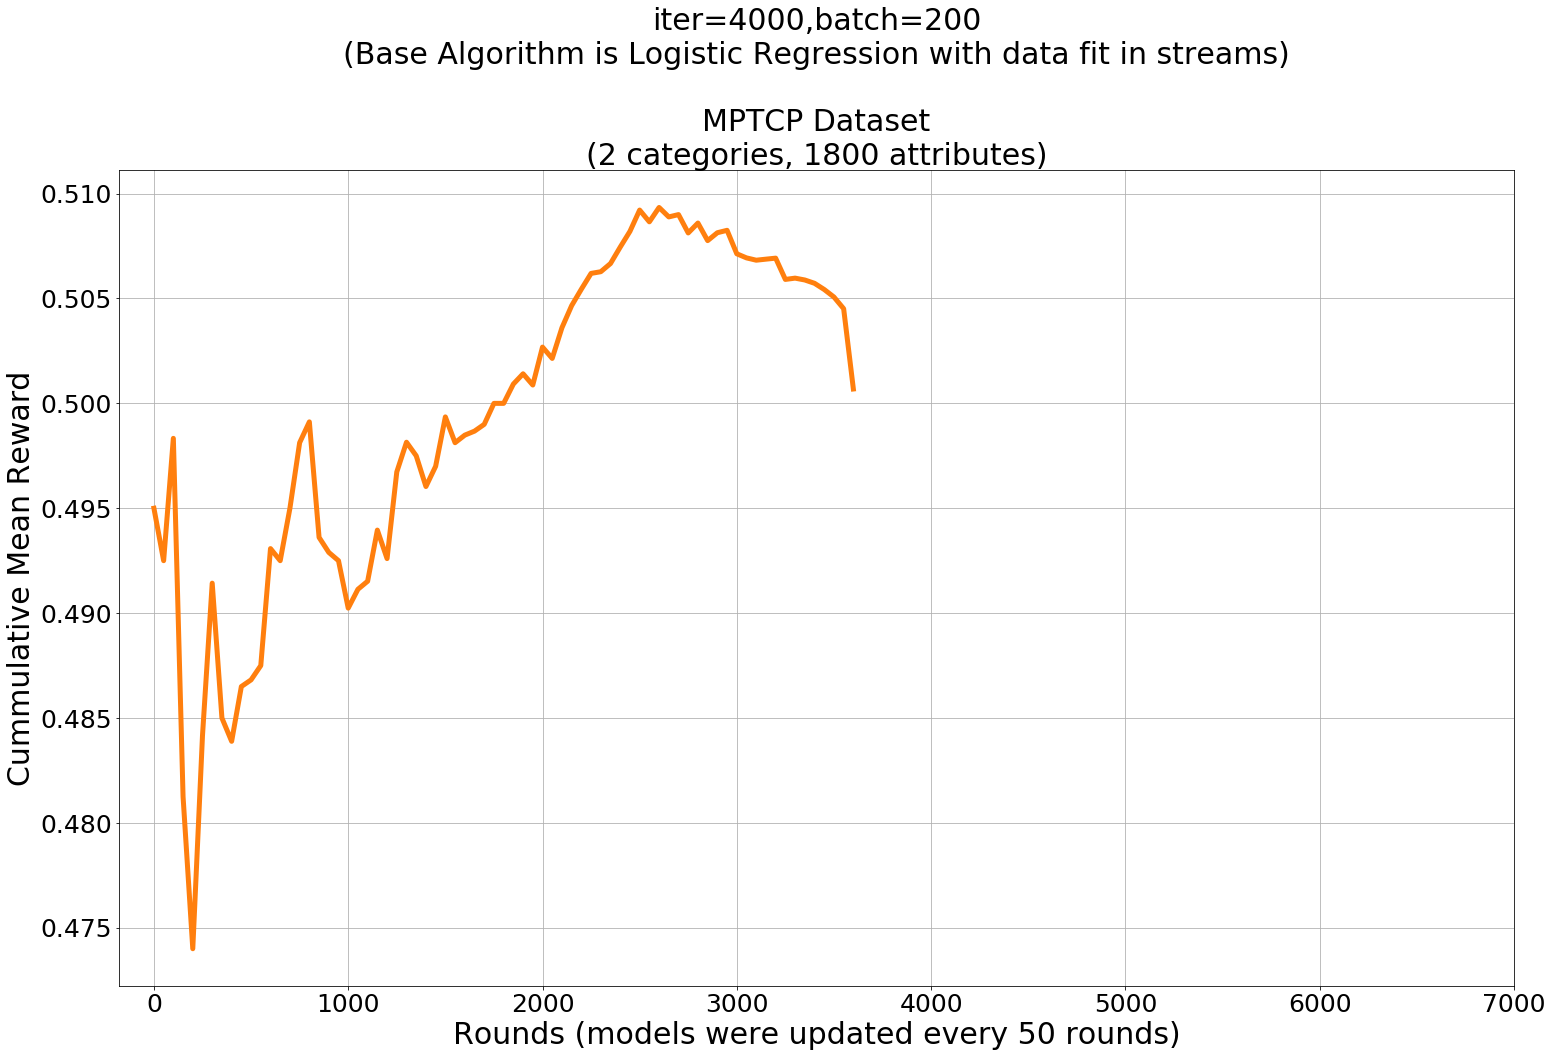

In [106]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=4000,batch=200\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

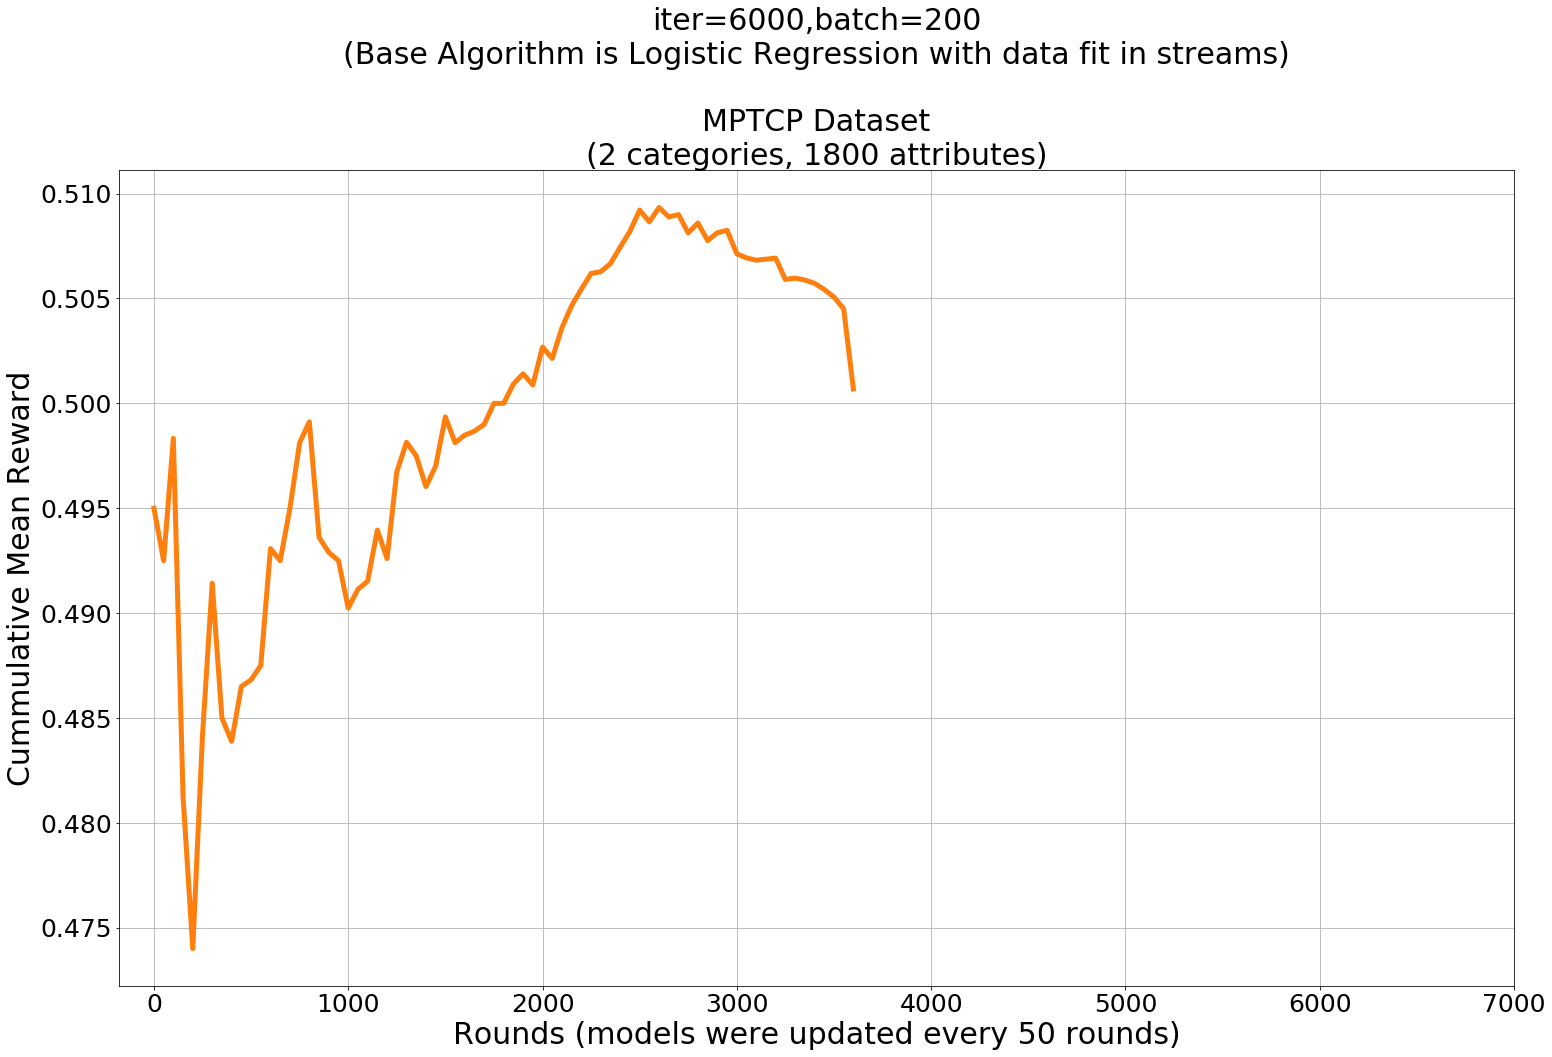

In [109]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=6000,batch=200\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

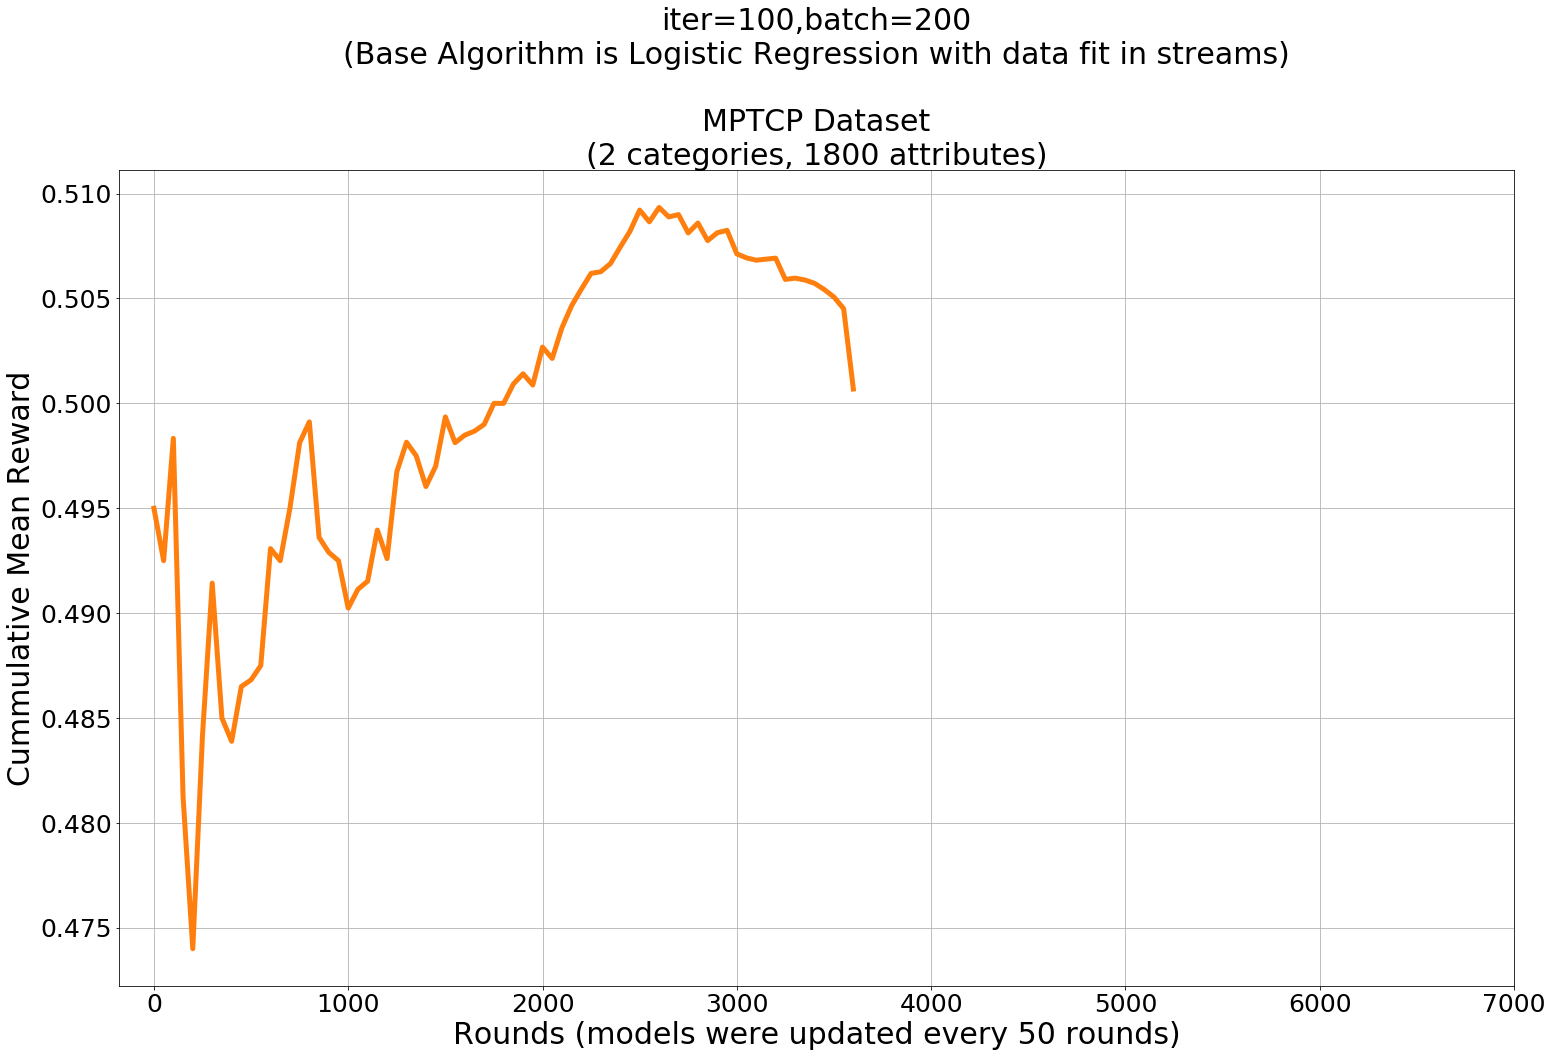

In [112]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=100,batch=200\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

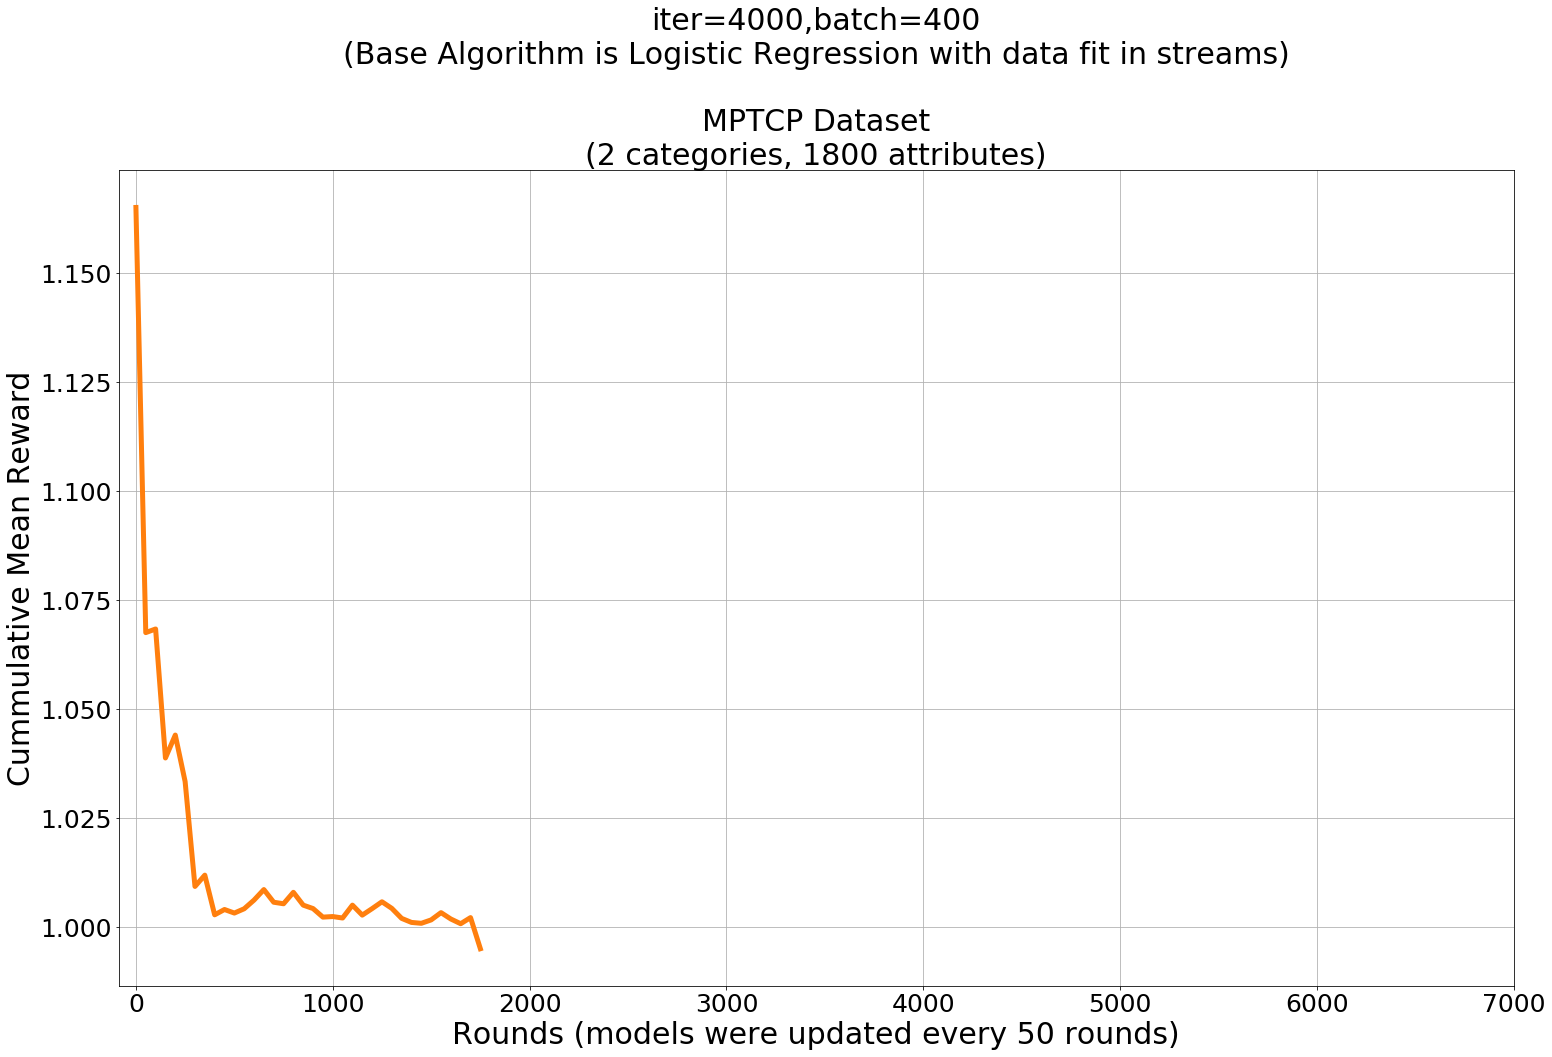

In [114]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=4000,batch=400\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

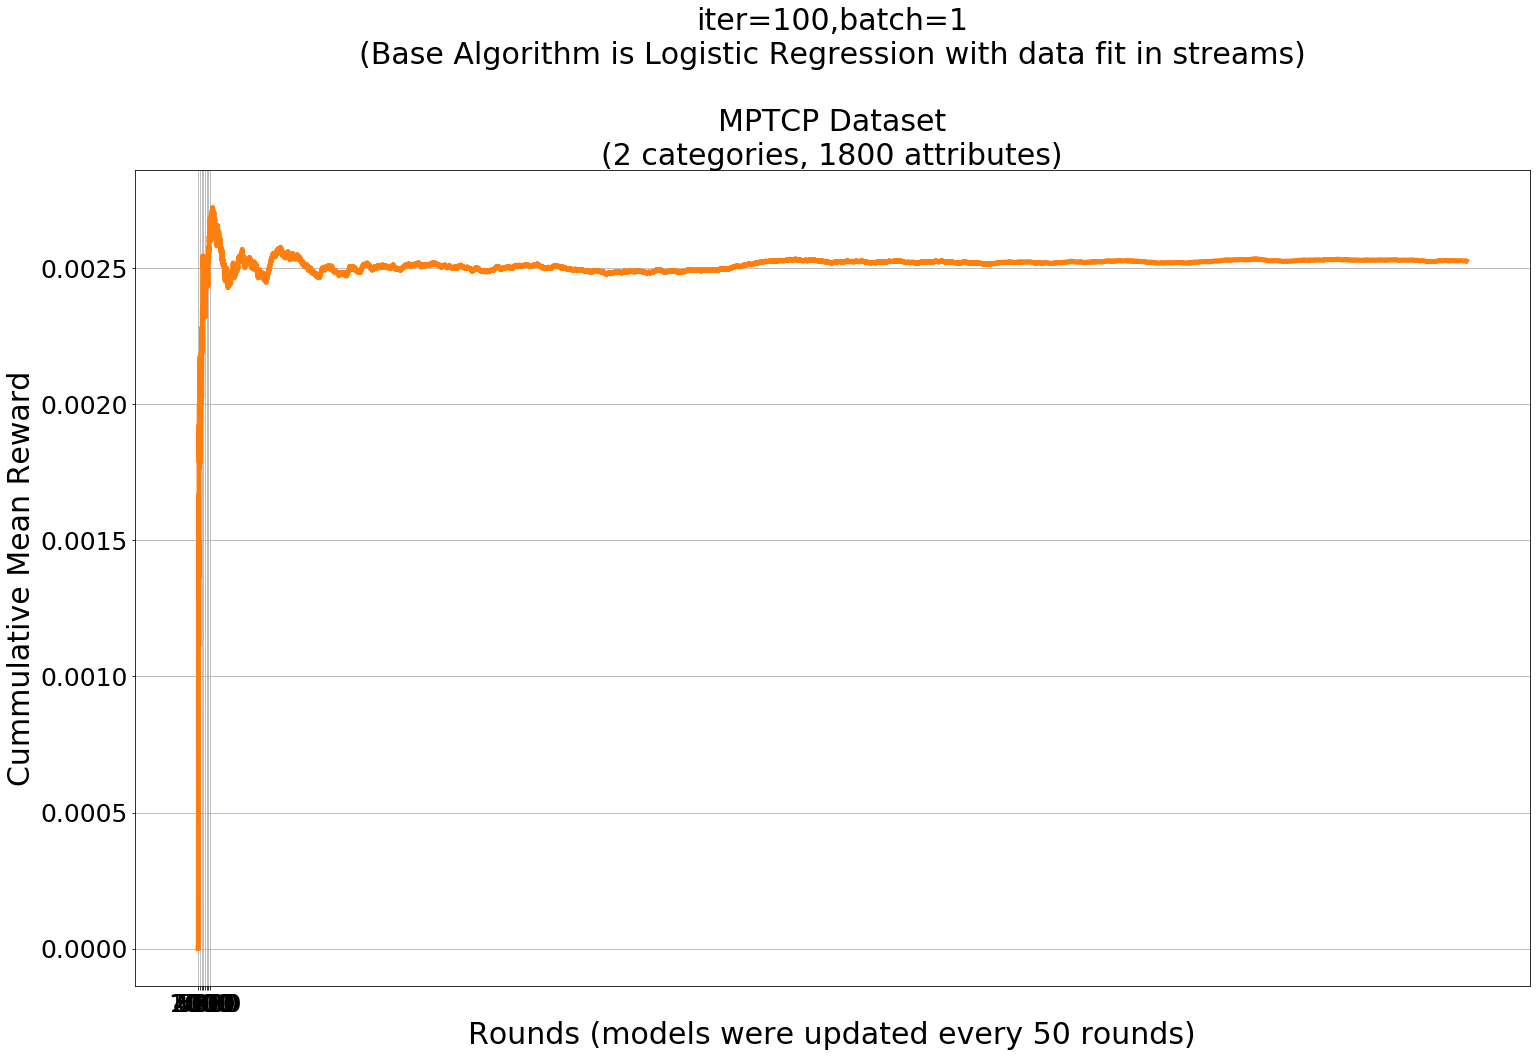

In [117]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=100,batch=1\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [121]:
#idx = np.random.randint(len(X))
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in range(5):
    action = models[0].predict(X[i]).astype("uint8")
    print(action)

[1]
[0]
[1]
[1]
[1]


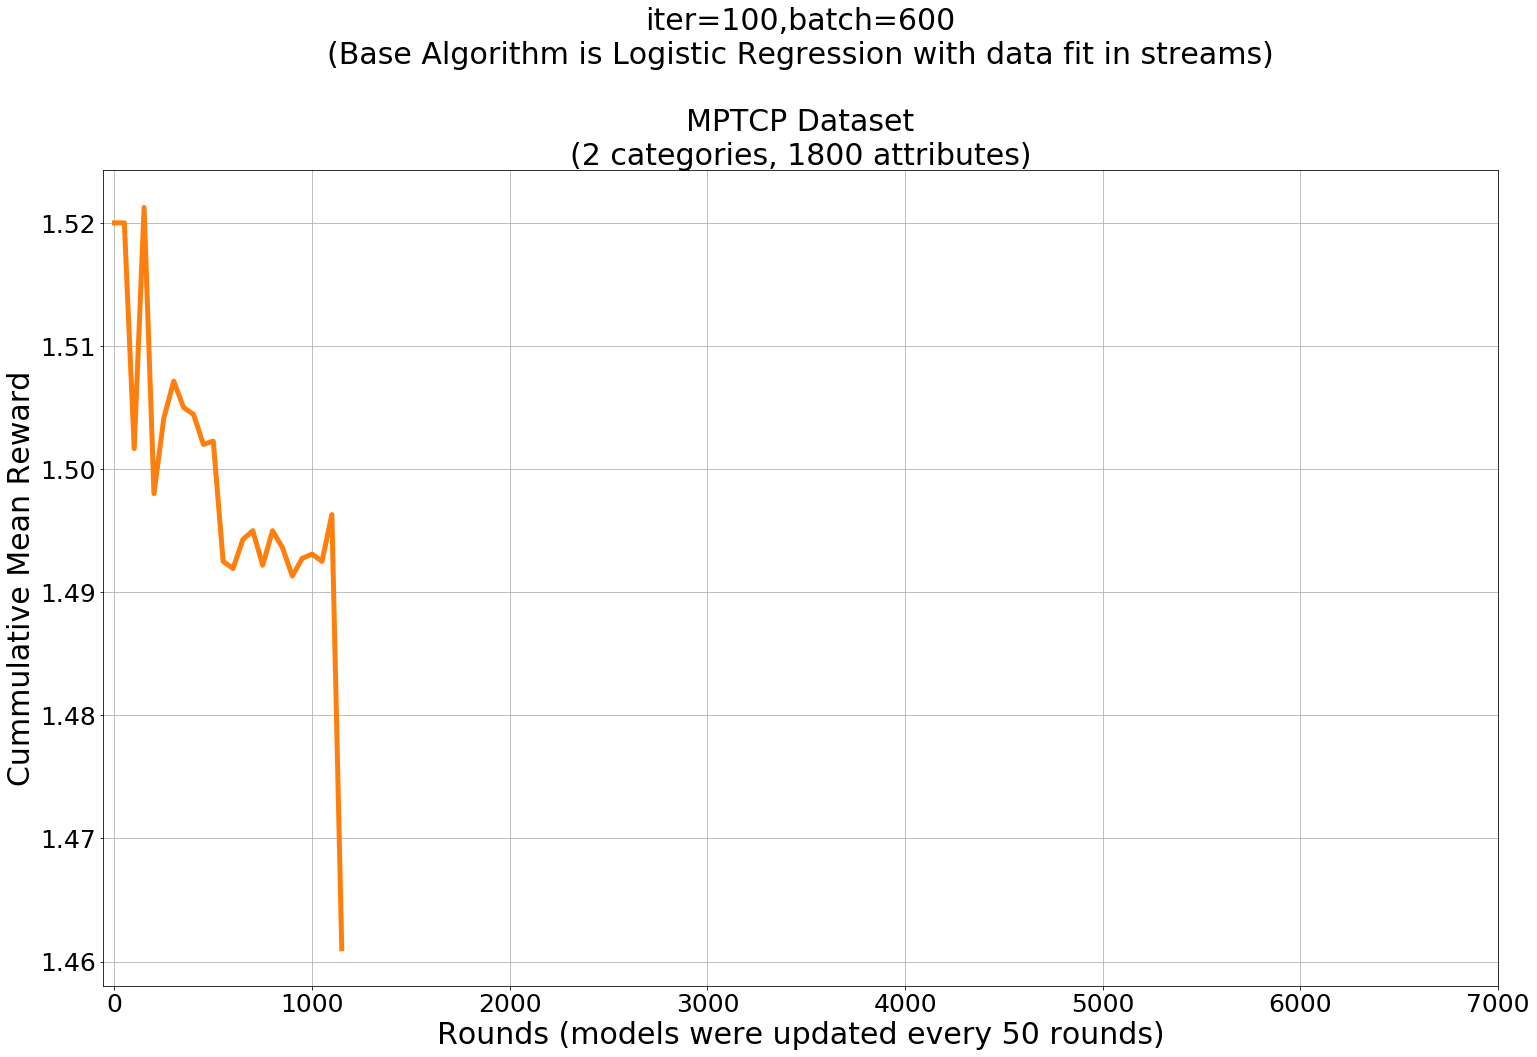

In [123]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=100,batch=600\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

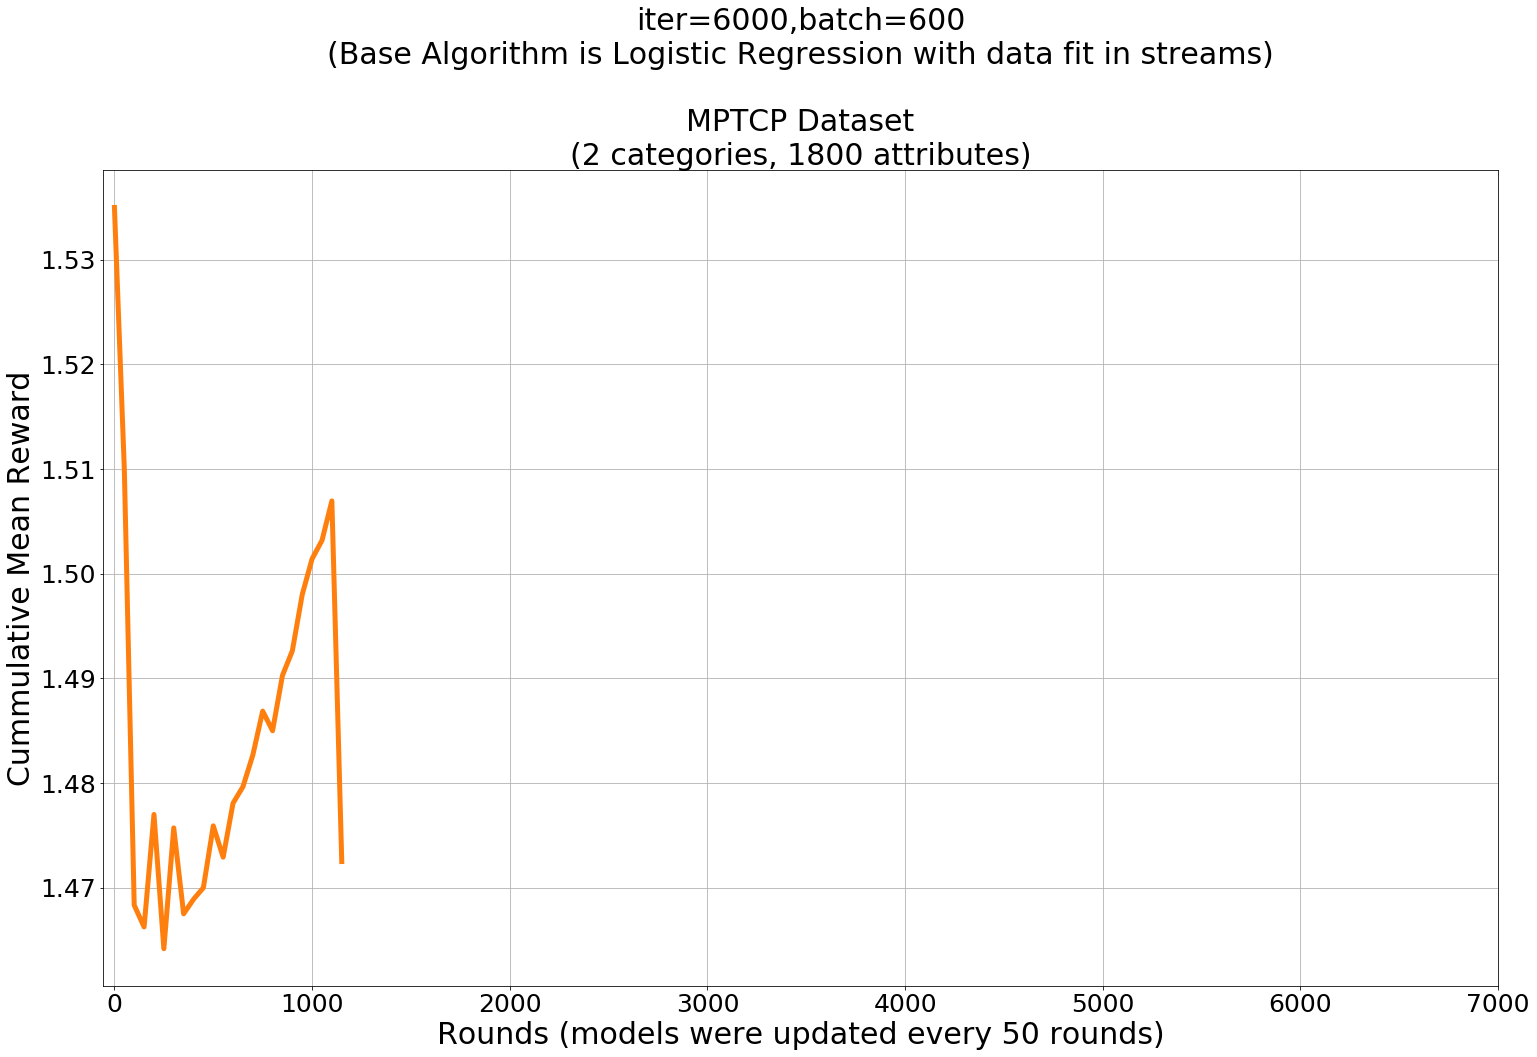

In [126]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=6000,batch=600\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [132]:
#idx = np.random.randint(len(X))
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in range(5):
    action = models[0].predict(X[i,:]).astype("uint8")
    print(action)

[1]
[1]
[1]
[1]
[1]


In [134]:
action = models[0].predict(X[13580, :]).astype("uint8")
print(action)

[1]


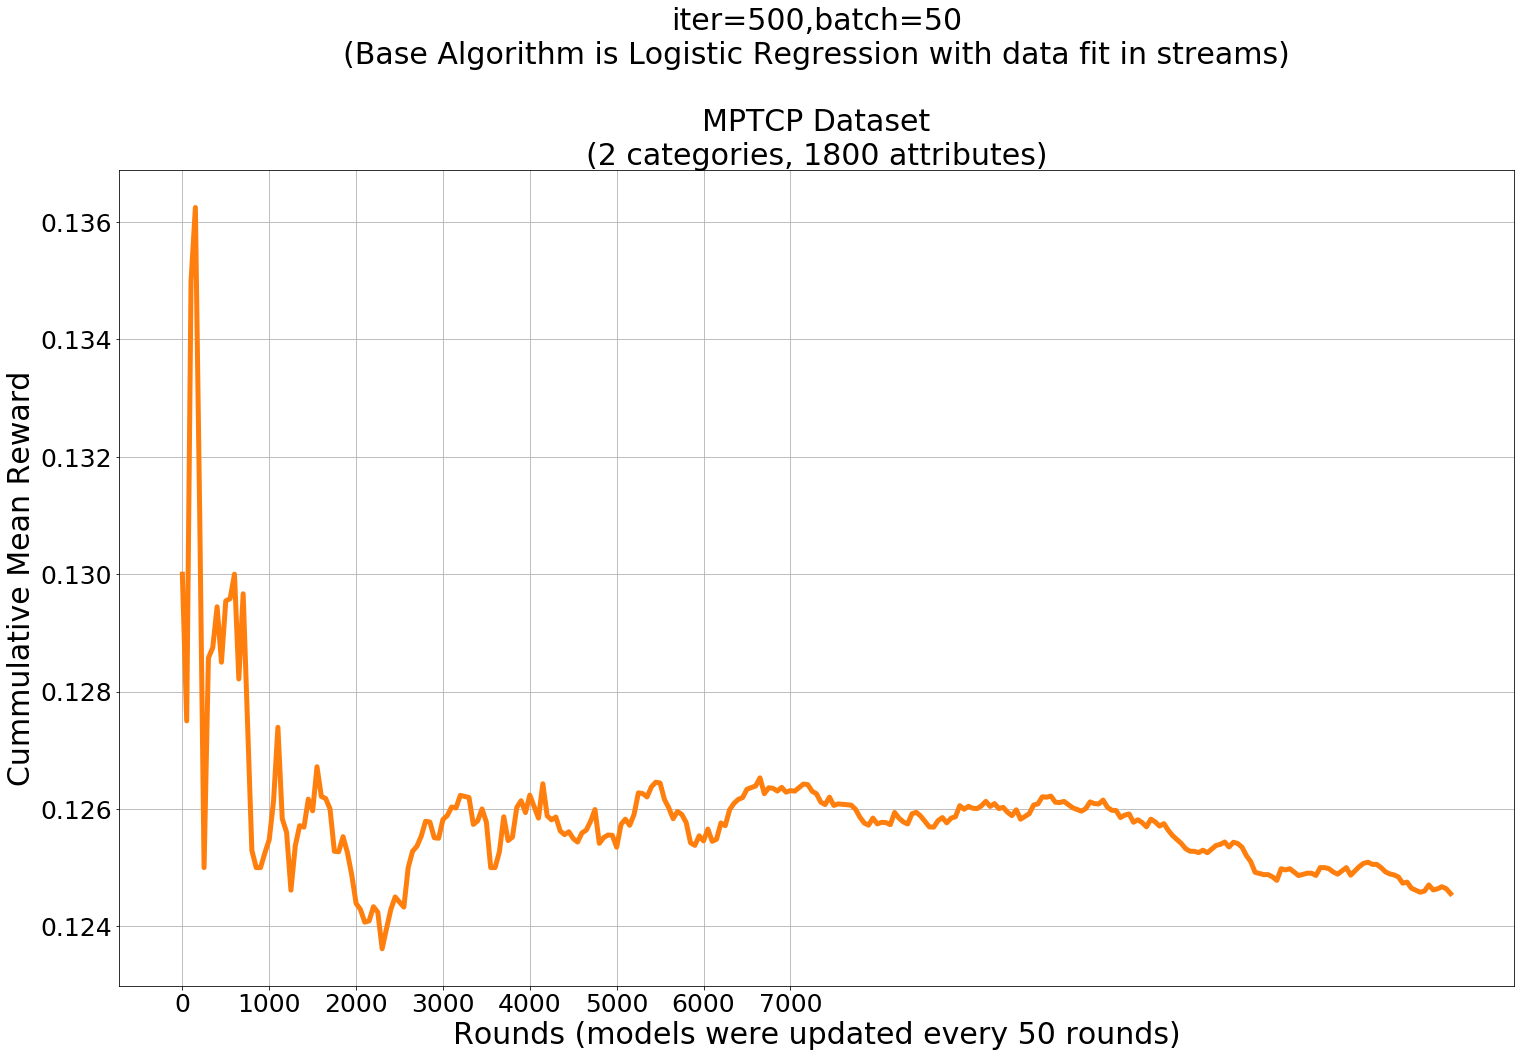

In [137]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=500,batch=50\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [143]:
action = models[0].predict(X[13580, :]).astype("uint8")
print(action)

[1]


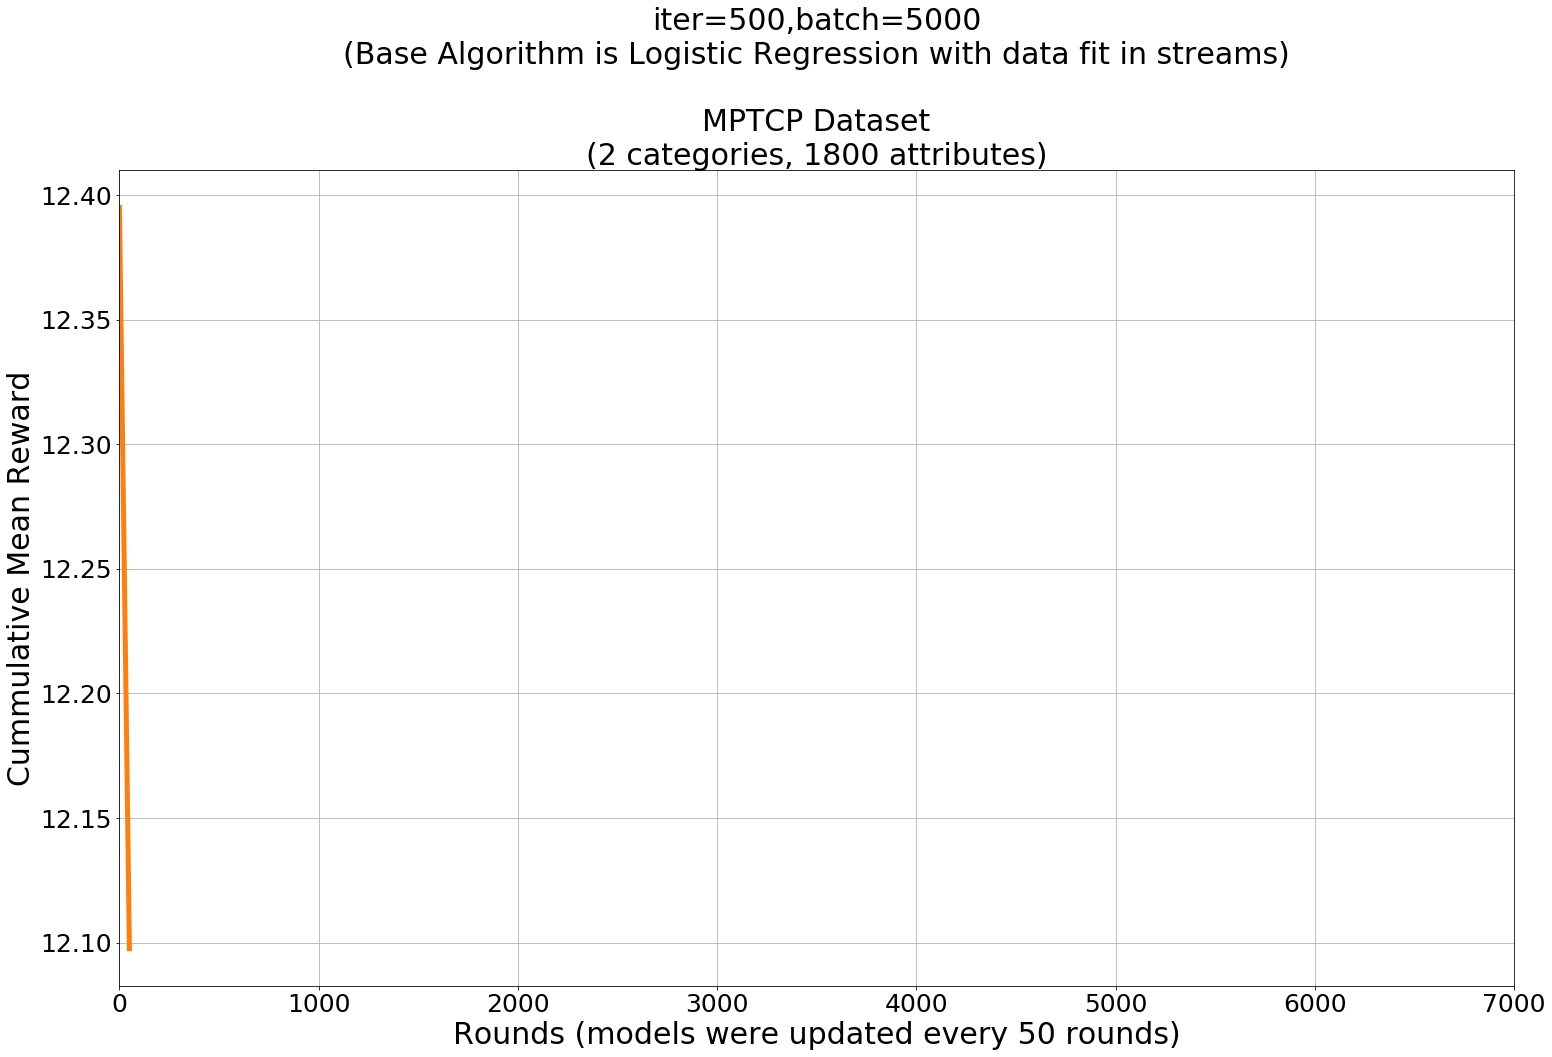

In [148]:
plt.plot(get_mean_reward(rewards_agr2), label="adaptive_greedy_perc", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=500,batch=5000\n(Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [154]:
action = models[0].predict(X[13580, :]).astype("uint8")
print(action)

[1]


In [163]:
action = models[0].predict(X[972]).astype("uint8")
print(action, y[972])

[1] [1 0]


In [164]:
for i in range(30):
    action = models[0].predict(X[972]).astype("uint8")
    print(action, y[972])

[1] [1 0]
[1] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[1] [1 0]
[0] [1 0]
[1] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[1] [1 0]
[1] [1 0]
[1] [1 0]
[0] [1 0]
[1] [1 0]
[1] [1 0]
[1] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[1] [1 0]
[0] [1 0]
[1] [1 0]
[1] [1 0]
[0] [1 0]


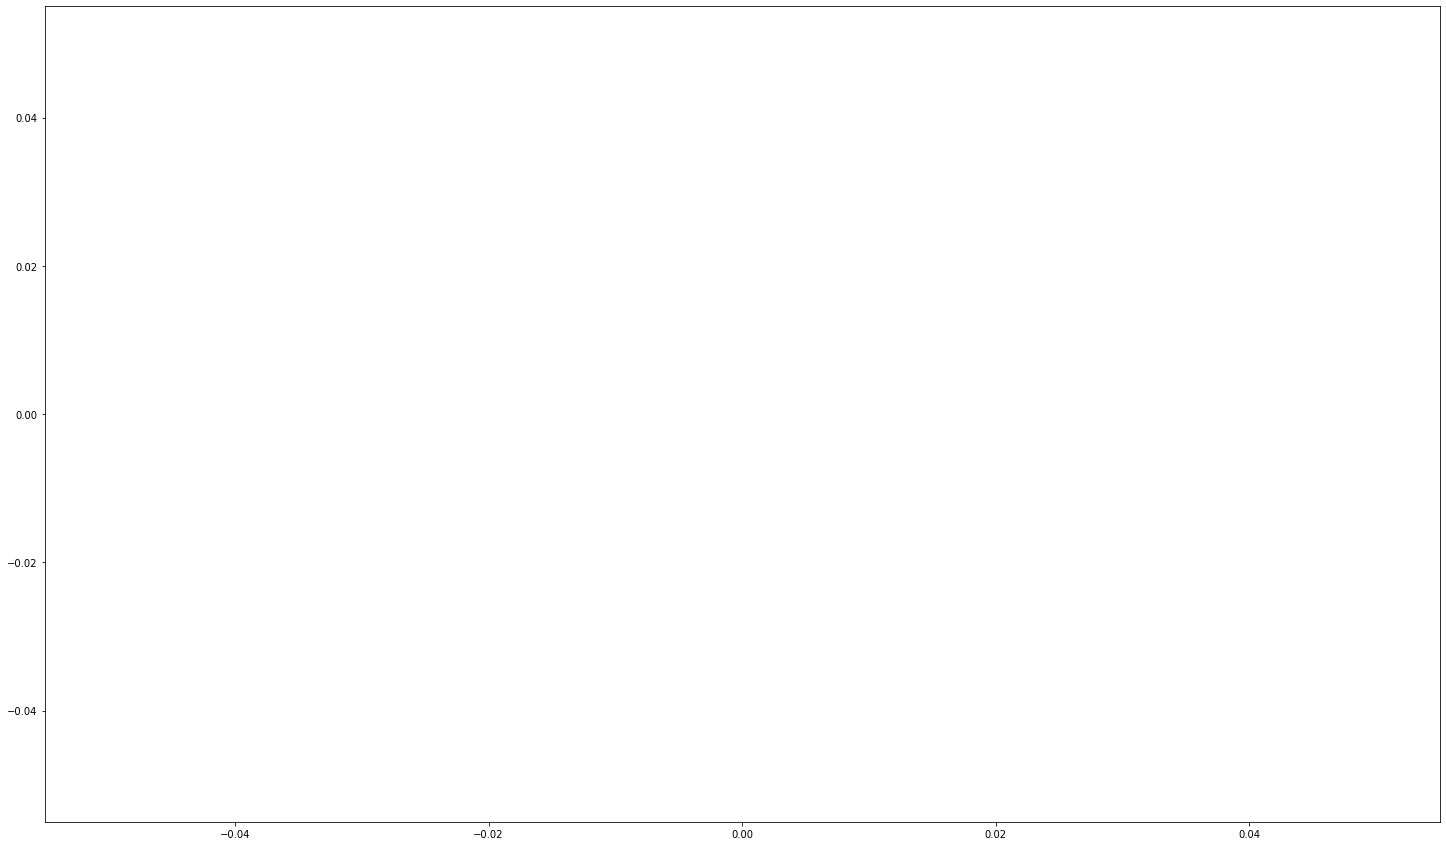

In [165]:
plt.plot(action)